In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = 'C:/Users/user/Downloads/CarInsurance'
data = pd.read_csv(path + '/CleanedDataCarInsurance.csv')

DATA CLEANING

In [4]:
data.isnull().sum()

ID                  0
marital_status      0
car_use             0
gender              0
kids_driving        0
parent              0
education           0
car_make            0
car_model           0
car_color           0
car_year            0
claim_freq          0
coverage_zone       0
claim_amt           0
household_income    0
birth_year          0
age                 0
dtype: int64

In [5]:
data.head(3)

,ID,marital_status,car_use,gender,kids_driving,parent,education,car_make,car_model,car_color,car_year,claim_freq,coverage_zone,claim_amt,household_income,birth_year,age
0,62-2999778,Single,Private,Male,2,Yes,High School,Acura,TSX,Green,2010,1,Highly Urban,73759.88,220436.66,1962,61
1,70-2426103,Married,Private,Female,0,No,Bachelors,Corbin,Sparrow,Turquoise,2004,1,Urban,78975.41,66491.43,1988,35
2,08-3808219,Divorced,Private,Male,0,No,Bachelors,Nissan,Pathfinder,Orange,1993,0,Rural,30904.01,56122.70,1999,24


In [6]:
data['age'] = 2023 - data['birth_year']

In [7]:
data.head(3)

,ID,marital_status,car_use,gender,kids_driving,parent,education,car_make,car_model,car_color,car_year,claim_freq,coverage_zone,claim_amt,household_income,birth_year,age
0,62-2999778,Single,Private,Male,2,Yes,High School,Acura,TSX,Green,2010,1,Highly Urban,73759.88,220436.66,1962,61
1,70-2426103,Married,Private,Female,0,No,Bachelors,Corbin,Sparrow,Turquoise,2004,1,Urban,78975.41,66491.43,1988,35
2,08-3808219,Divorced,Private,Male,0,No,Bachelors,Nissan,Pathfinder,Orange,1993,0,Rural,30904.01,56122.70,1999,24


<Axes: xlabel='claim_amt', ylabel='Density'>

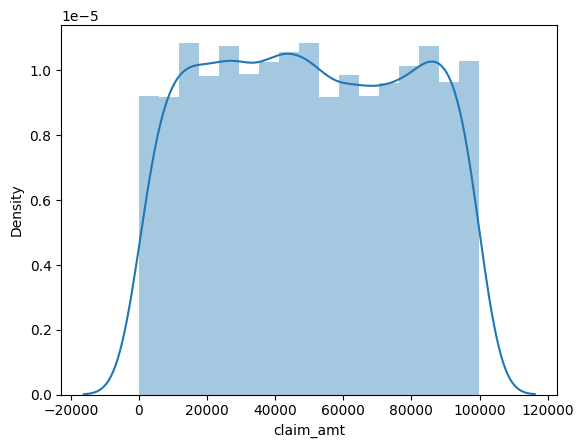

In [8]:
#Let's check the distribution of the target variable.
sns.distplot(data["claim_amt"])

In [163]:
skewness = data["claim_amt"].skew()
print(f"The skewness of Claim Amount is {skewness}")

TypeError: list indices must be integers or slices, not str

In [10]:
numeric_data = data.select_dtypes(include=[np.number])
cat_data = data.select_dtypes(exclude=[np.number])
print ("There are {} numeric and {} categorical columns in train data".format(numeric_data.shape[1],cat_data.shape[1]))

There are 7 numeric and 10 categorical columns in train data


In [12]:
del cat_data['ID']

<Axes: >

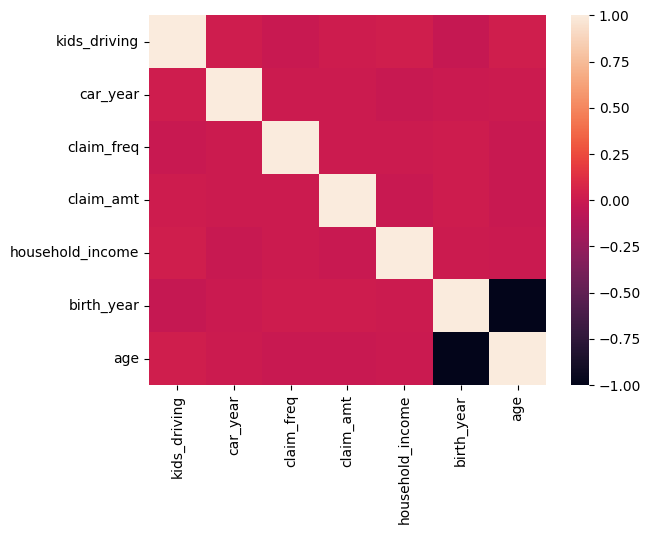

In [13]:
#correlation plot
corr = numeric_data.corr()

sns.heatmap(corr)

In [15]:
print(corr["claim_amt"].sort_values(ascending = False))

claim_amt           1.000000
kids_driving        0.015602
birth_year          0.012264
car_year            0.006349
claim_freq          0.004396
household_income   -0.011608
age                -0.012264
Name: claim_amt, dtype: float64


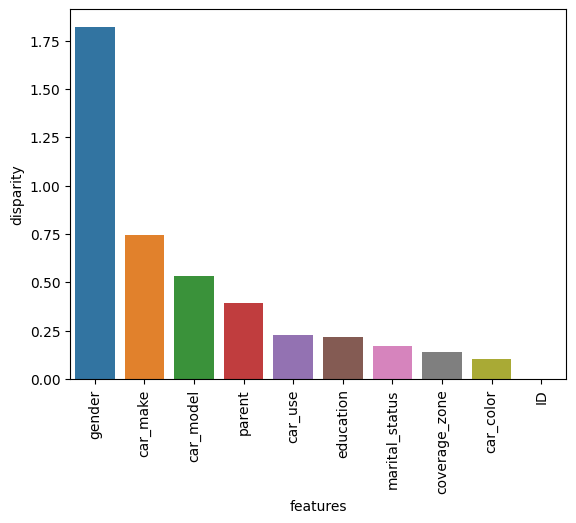

In [21]:
from scipy import stats
cat = [col for col in data.columns if data.dtypes[col] == 'object']


anv = pd.DataFrame()
anv['features'] = cat
pvals = []

cat_data = data.copy()
cat_data['claim_amt'] = data['claim_amt'].values

for c in cat:
     samples = []
     for cls in cat_data[c].unique():
           s = cat_data[cat_data[c] == cls]['claim_amt'].values
           samples.append(s)
     pval = stats.f_oneway(*samples)[1]
     pvals.append(pval)
     
anv['pval'] = pvals
anv['disparity'] = np.log(1. / anv['pval'].values)

anv = anv.sort_values(by='disparity',ascending=False)

sns.barplot(data=anv, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt.show() 

In [102]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
le = LabelEncoder()

In [103]:
from sklearn.preprocessing import LabelEncoder

def processing_data(data):

    processed_data = data.copy()

    dummy = ['car_make','car_use'] 
    
    processed_data = pd.get_dummies(processed_data, columns = dummy)

    categ=['gender']

    if 'ID' in processed_data:
        processed_data.drop(['ID'], axis=1,inplace=True)

    le = LabelEncoder()    

    for col in categ:
        processed_data[col] = le.fit_transform(data[col]) 
    
    return pd.DataFrame(processed_data, columns=processed_data.columns)

In [104]:
processed_X = processing_data(X)

In [165]:
processed_X.shape

(4228, 77)

In [106]:
processed_X = processed_X.drop(['car_model'],axis=1)

In [114]:
processed_X = processed_X.drop(['marital_status','parent','education','car_color','car_year','claim_freq',
                                'coverage_zone','household_income'],axis=1)

In [116]:
processed_X = processed_X.drop(['age'],axis=1)

In [149]:
processed_X.head(2)

,gender,kids_driving,birth_year,car_make_Acura,car_make_Alfa Romeo,car_make_Aptera,car_make_Aston Martin,car_make_Audi,car_make_Austin,car_make_BMW,...,car_make_Spyker,car_make_Studebaker,car_make_Subaru,car_make_Suzuki,car_make_Tesla,car_make_Toyota,car_make_Volkswagen,car_make_Volvo,car_use_Commercial,car_use_Private
0,1,2,1962,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1988,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [150]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import cross_val_score,KFold
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRFRegressor,XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [151]:
X_train,X_test,y_train,y_test = train_test_split(processed_X, y,
                                                 test_size=0.1,random_state=42)

In [152]:
k_best_features = 50
selector = SelectKBest(score_func=f_regression,k = k_best_features)
selector.fit(X_train,y_train)
X_train_selected = selector.fit_transform(X_train,y_train)
X_test_selected = selector.transform(X_test)

In [153]:
'''
def calculate_mae(y_pred,y_test):
     return mean_absolute_error(y_pred,y_test)

models = {
     "LinearRegression": LinearRegression(),
     "DecisionTree": DecisionTreeRegressor(random_state=42),
     "RandomForest": RandomForestRegressor(random_state=42),
     "GradientBoost": GradientBoostingRegressor(random_state=42),
     "XGBRF": XGBRFRegressor(),
     "XGR": XGBRegressor()
     }
mae_values = []
#mse_values = []

for name,model in models.items():
    model.fit(X_train_selected,y_train)
    preds = model.predict(X_test_selected)
    mae_values.append(calculate_mae(y_test,preds))
    #mse_values.append(mean_squared_error(y_test,preds))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x =list(models.keys()),y = mae_values, palette='viridis')
plt.title("MAE of Models")
plt.ylabel("MAE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.barplot(x =list(models.keys()),y = mse_values, palette='viridis')
plt.title("MSE of Models")
plt.ylabel("MSE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
'''

'\ndef calculate_mae(y_pred,y_test):\n     return mean_absolute_error(y_pred,y_test)\n\nmodels = {\n     "LinearRegression": LinearRegression(),\n     "DecisionTree": DecisionTreeRegressor(random_state=42),\n     "RandomForest": RandomForestRegressor(random_state=42),\n     "GradientBoost": GradientBoostingRegressor(random_state=42),\n     "XGBRF": XGBRFRegressor(),\n     "XGR": XGBRegressor()\n     }\nmae_values = []\n#mse_values = []\n\nfor name,model in models.items():\n    model.fit(X_train_selected,y_train)\n    preds = model.predict(X_test_selected)\n    mae_values.append(calculate_mae(y_test,preds))\n    #mse_values.append(mean_squared_error(y_test,preds))\n\nplt.figure(figsize=(12,5))\n\nplt.subplot(1,2,1)\nsns.barplot(x =list(models.keys()),y = mae_values, palette=\'viridis\')\nplt.title("MAE of Models")\nplt.ylabel("MAE")\nplt.xticks(rotation=90)\n\nplt.tight_layout()\nplt.show()\n\nplt.subplot(1,2,1)\nsns.barplot(x =list(models.keys()),y = mse_values, palette=\'viridis\')\np

In [154]:
#gb = GradientBoostingRegressor()
xrf = XGBRFRegressor()
lr = LinearRegression()
'''
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
maegb = mean_absolute_error(y_test,y_pred)
'''
xrf.fit(X_train_selected,y_train)
xrf_pred = xrf.predict(X_test_selected)
maexrf = mean_absolute_error(y_test,y_pred)

lr.fit(X_train_selected,y_train)
lr_pred = lr.predict(X_test_selected)
maelr = mean_absolute_error(y_test,y_pred)

#print(f"MAE of Gradient Boosting is: {maegb:.4f}")
print(f"MAE of XGBRFRegressor is: {maexrf:.4f}")
print(f"MAE of LinearRegression is: {maelr:.4f}")

MAE of XGBRFRegressor is: 24687.5105
MAE of LinearRegression is: 24687.5105


In [158]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_selected)
X_test = scaler.transform(X_test_selected)

def base_model():
     model = Sequential()
     model.add(Dense(units = 20, input_dim=50, kernel_initializer='uniform', activation='relu'))
     model.add(Dense(units =10, kernel_initializer='uniform', activation='relu'))
     model.add(Dense(units =1, kernel_initializer='uniform'))
     model.compile(loss='mean_absolute_error', optimizer = 'adam')
     return model

keras_model = base_model()
keras_model.fit(X_train_selected,y_train,epochs=10, batch_size=5,verbose=1)
y_pred = keras_model.predict(X_test_selected)

mae_scores = mean_absolute_error(y_test,y_pred)

print("MAE:" ,mae_scores)

Epoch 1/10
761/761 [==============================] - 3s 2ms/step - loss: 34654.3555
Epoch 2/10
761/761 [==============================] - 1s 2ms/step - loss: 24874.9766
Epoch 3/10
761/761 [==============================] - 2s 2ms/step - loss: 24863.2871
Epoch 4/10
761/761 [==============================] - 1s 2ms/step - loss: 24875.2891
Epoch 5/10
761/761 [==============================] - 1s 2ms/step - loss: 24873.4961
Epoch 6/10
761/761 [==============================] - 1s 2ms/step - loss: 24854.6523
Epoch 7/10
761/761 [==============================] - 1s 2ms/step - loss: 24876.4336
Epoch 8/10
761/761 [==============================] - 1s 2ms/step - loss: 24881.9414
Epoch 9/10
761/761 [==============================] - 1s 2ms/step - loss: 24876.5996
Epoch 10/10
14/14 [==============================] - 0s 1ms/step
MAE: 24692.21253952423


In [159]:
ensemble_predictions = (xrf_pred + lr_pred) / 2

ensemble_mae = mean_absolute_error(y_test,ensemble_predictions)
print(f"Ensemble Mean Absolute Error: {ensemble_mae:.4f}")

Ensemble Mean Absolute Error: 24820.6873
